# How to manage conversation history in a ReAct Agent

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [Prebuilt create_react_agent](../create-react-agent)
    - [Persistence](../../concepts/persistence)
    - [Short-term Memory](../../concepts/memory/#short-term-memory)
    - [Trimming Messages](https://python.langchain.com/docs/how_to/trim_messages/)

Message history can grow quickly and exceed LLM context window size, whether you're building chatbots with many conversation turns or agentic systems with numerous tool calls. There are several strategies for managing the message history:

* [message trimming](#keep-the-original-message-history-unmodified) — remove first or last N messages in the history
* [summarization](#summarizing-message-history) — summarize earlier messages in the history and replace them with a summary
* custom strategies (e.g., message filtering, etc.)

To manage message history in `create_react_agent`, you need to define a `pre_model_hook` function or [runnable](https://python.langchain.com/docs/concepts/runnables/) that takes graph state an returns a state update:


* Trimming example:
    ```python
    # highlight-next-line
    from langchain_core.messages.utils import (
        # highlight-next-line
        trim_messages, 
        # highlight-next-line
        count_tokens_approximately
    # highlight-next-line
    )
    from langgraph.prebuilt import create_react_agent
    
    # This function will be called every time before the node that calls LLM
    def pre_model_hook(state):
        trimmed_messages = trim_messages(
            state["messages"],
            strategy="last",
            token_counter=count_tokens_approximately,
            max_tokens=384,
            start_on="human",
            end_on=("human", "tool"),
        )
        # You can return updated messages either under `llm_input_messages` or 
        # `messages` key (see the note below)
        # highlight-next-line
        return {"llm_input_messages": trimmed_messages}

    checkpointer = InMemorySaver()
    agent = create_react_agent(
        model,
        tools,
        # highlight-next-line
        pre_model_hook=pre_model_hook,
        checkpointer=checkpointer,
    )
    ```

* Summarization example:
    ```python
    # highlight-next-line
    from langmem.short_term import SummarizationNode
    from langchain_core.messages.utils import count_tokens_approximately
    from langgraph.prebuilt.chat_agent_executor import AgentState
    from langgraph.checkpoint.memory import InMemorySaver
    from typing import Any
    
    model = ChatOpenAI(model="gpt-4o")
    
    summarization_node = SummarizationNode(
        token_counter=count_tokens_approximately,
        model=model,
        max_tokens=384,
        max_summary_tokens=128,
        output_messages_key="llm_input_messages",
    )

    class State(AgentState):
        # NOTE: we're adding this key to keep track of previous summary information
        # to make sure we're not summarizing on every LLM call
        # highlight-next-line
        context: dict[str, Any]
    
    
    checkpointer = InMemorySaver()
    graph = create_react_agent(
        model,
        tools,
        # highlight-next-line
        pre_model_hook=summarization_node,
        # highlight-next-line
        state_schema=State,
        checkpointer=checkpointer,
    )
    ```

!!! Important
    
    * To **keep the original message history unmodified** in the graph state and pass the updated history **only as the input to the LLM**, return updated messages under `llm_input_messages` key
    * To **overwrite the original message history** in the graph state with the updated history, return updated messages under `messages` key
    
    To overwrite the `messages` key, you need to do the following:

    ```python
    from langchain_core.messages import RemoveMessage
    from langgraph.graph.message import REMOVE_ALL_MESSAGES

    def pre_model_hook(state):
        updated_messages = ...
        return {
            "messages": [RemoveMessage(id=REMOVE_ALL_MESSAGES), *updated_messages]
            ...
        }
    ```

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai langmem

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Keep the original message history unmodified

Let's build a ReAct agent with a step that manages the conversation history: when the length of the history exceeds a specified number of tokens, we will call [`trim_messages`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.utils.trim_messages.html) utility that that will reduce the history while satisfying LLM provider constraints.

There are two ways that the updated message history can be applied inside ReAct agent:

  * [**Keep the original message history unmodified**](#keep-the-original-message-history-unmodified) in the graph state and pass the updated history **only as the input to the LLM**
  * [**Overwrite the original message history**](#overwrite-the-original-message-history) in the graph state with the updated history

Let's start by implementing the first one. We'll need to first define model and tools for our agent:

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)


def get_weather(location: str) -> str:
    """Use this to get weather information."""
    if any([city in location.lower() for city in ["nyc", "new york city"]]):
        return "It might be cloudy in nyc, with a chance of rain and temperatures up to 80 degrees."
    elif any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's always sunny in sf"
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

Now let's implement `pre_model_hook` — a function that will be added as a new node and called every time **before** the node that calls the LLM (the `agent` node).

Our implementation will wrap the `trim_messages` call and return the trimmed messages under `llm_input_messages`. This will **keep the original message history unmodified** in the graph state and pass the updated history **only as the input to the LLM**

In [4]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

# highlight-next-line
from langchain_core.messages.utils import (
    # highlight-next-line
    trim_messages,
    # highlight-next-line
    count_tokens_approximately,
    # highlight-next-line
)


# This function will be added as a new node in ReAct agent graph
# that will run every time before the node that calls the LLM.
# The messages returned by this function will be the input to the LLM.
def pre_model_hook(state):
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=384,
        start_on="human",
        end_on=("human", "tool"),
    )
    # highlight-next-line
    return {"llm_input_messages": trimmed_messages}


checkpointer = InMemorySaver()
graph = create_react_agent(
    model,
    tools,
    # highlight-next-line
    pre_model_hook=pre_model_hook,
    checkpointer=checkpointer,
)

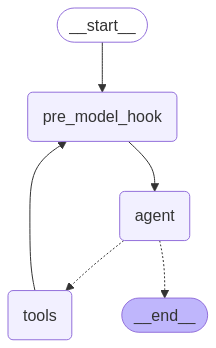

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

We'll also define a utility to render the agent outputs nicely:

In [6]:
def print_stream(stream, output_messages_key="llm_input_messages"):
    for chunk in stream:
        for node, update in chunk.items():
            print(f"Update from node: {node}")
            messages_key = (
                output_messages_key if node == "pre_model_hook" else "messages"
            )
            for message in update[messages_key]:
                if isinstance(message, tuple):
                    print(message)
                else:
                    message.pretty_print()

        print("\n\n")

Now let's run the agent with a few different queries to reach the specified max tokens limit:

In [7]:
config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [("user", "What's the weather in NYC?")]}
result = graph.invoke(inputs, config=config)

inputs = {"messages": [("user", "What's it known for?")]}
result = graph.invoke(inputs, config=config)

Let's see how many tokens we have in the message history so far:

In [8]:
messages = result["messages"]
count_tokens_approximately(messages)

415

You can see that we are close to the `max_tokens` threshold, so on the next invocation we should see `pre_model_hook` kick-in and trim the message history. Let's run it again:

In [9]:
inputs = {"messages": [("user", "where can i find the best bagel?")]}
print_stream(graph.stream(inputs, config=config, stream_mode="updates"))

Update from node: pre_model_hook
================================ Human Message =================================

What's it known for?
================================== Ai Message ==================================

New York City is known for a variety of iconic landmarks, cultural institutions, and vibrant neighborhoods. Some of the most notable features include:

1. **Statue of Liberty**: A symbol of freedom and democracy, located on Liberty Island.
2. **Times Square**: Known for its bright lights, Broadway theaters, and bustling atmosphere.
3. **Central Park**: A large public park offering a natural retreat in the middle of the city.
4. **Empire State Building**: An iconic skyscraper offering panoramic views of the city.
5. **Broadway**: Famous for its world-class theater productions.
6. **Wall Street**: The financial hub of the United States.
7. **Museums**: Including the Metropolitan Museum of Art, Museum of Modern Art (MoMA), and the American Museum of Natural History.
8. **Div

You can see that the `pre_model_hook` node now only returned the last 3 messages, as expected. However, the existing message history is untouched:

In [10]:
updated_messages = graph.get_state(config).values["messages"]
assert [(m.type, m.content) for m in updated_messages[: len(messages)]] == [
    (m.type, m.content) for m in messages
]

## Overwrite the original message history

Let's now change the `pre_model_hook` to **overwrite** the message history in the graph state. To do this, we’ll return the updated messages under `messages` key. We’ll also include a special `RemoveMessage(REMOVE_ALL_MESSAGES)` object, which tells `create_react_agent` to remove previous messages from the graph state:

In [11]:
from langchain_core.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES


def pre_model_hook(state):
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=384,
        start_on="human",
        end_on=("human", "tool"),
    )
    # NOTE that we're now returning the messages under the `messages` key
    # We also remove the existing messages in the history to ensure we're overwriting the history
    # highlight-next-line
    return {"messages": [RemoveMessage(REMOVE_ALL_MESSAGES)] + trimmed_messages}


checkpointer = InMemorySaver()
graph = create_react_agent(
    model,
    tools,
    # highlight-next-line
    pre_model_hook=pre_model_hook,
    checkpointer=checkpointer,
)

Now let's run the agent with the same queries as before:

In [12]:
config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [("user", "What's the weather in NYC?")]}
result = graph.invoke(inputs, config=config)

inputs = {"messages": [("user", "What's it known for?")]}
result = graph.invoke(inputs, config=config)
messages = result["messages"]

inputs = {"messages": [("user", "where can i find the best bagel?")]}
print_stream(
    graph.stream(inputs, config=config, stream_mode="updates"),
    output_messages_key="messages",
)

Update from node: pre_model_hook
================================ Remove Message ================================


================================ Human Message =================================

What's it known for?
================================== Ai Message ==================================

New York City is known for a variety of iconic landmarks, cultural institutions, and vibrant neighborhoods. Some of the most notable features include:

1. **Statue of Liberty**: A symbol of freedom and democracy, located on Liberty Island.
2. **Times Square**: Known for its bright lights, Broadway theaters, and bustling atmosphere.
3. **Central Park**: A large public park offering a natural oasis amidst the urban environment.
4. **Empire State Building**: An iconic skyscraper offering panoramic views of the city.
5. **Broadway**: Famous for its world-class theater productions and musicals.
6. **Wall Street**: The financial hub of the United States, located in the Financial District.
7. **Mu

You can see that the `pre_model_hook` node returned the last 3 messages again. However, this time, the message history is modified in the graph state as well:

In [13]:
updated_messages = graph.get_state(config).values["messages"]
assert (
    # First 2 messages in the new history are the same as last 2 messages in the old
    [(m.type, m.content) for m in updated_messages[:2]]
    == [(m.type, m.content) for m in messages[-2:]]
)

## Summarizing message history

Finally, let's apply a different strategy for managing message history — summarization. Just as with trimming, you can choose to keep original message history unmodified or overwrite it. The example below will only show the former.

We will use the [`SummarizationNode`](https://langchain-ai.github.io/langmem/guides/summarization/#using-summarizationnode) from the prebuilt `langmem` library. Once the message history reaches the token limit, the summarization node will summarize earlier messages to make sure they fit into `max_tokens`.

In [14]:
# highlight-next-line
from langmem.short_term import SummarizationNode
from langgraph.prebuilt.chat_agent_executor import AgentState
from typing import Any

model = ChatOpenAI(model="gpt-4o")
summarization_model = model.bind(max_tokens=128)

summarization_node = SummarizationNode(
    token_counter=count_tokens_approximately,
    model=summarization_model,
    max_tokens=384,
    max_summary_tokens=128,
    output_messages_key="llm_input_messages",
)


class State(AgentState):
    # NOTE: we're adding this key to keep track of previous summary information
    # to make sure we're not summarizing on every LLM call
    # highlight-next-line
    context: dict[str, Any]


checkpointer = InMemorySaver()
graph = create_react_agent(
    # limit the output size to ensure consistent behavior
    model.bind(max_tokens=256),
    tools,
    # highlight-next-line
    pre_model_hook=summarization_node,
    # highlight-next-line
    state_schema=State,
    checkpointer=checkpointer,
)

In [15]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [("user", "What's the weather in NYC?")]}

result = graph.invoke(inputs, config=config)

inputs = {"messages": [("user", "What's it known for?")]}
result = graph.invoke(inputs, config=config)

inputs = {"messages": [("user", "where can i find the best bagel?")]}
print_stream(graph.stream(inputs, config=config, stream_mode="updates"))

Update from node: pre_model_hook
================================ System Message ================================

Summary of the conversation so far: The user asked about the current weather in New York City. In response, the assistant provided information that it might be cloudy, with a chance of rain, and temperatures reaching up to 80 degrees.
================================ Human Message =================================

What's it known for?
================================== Ai Message ==================================

New York City, often referred to as NYC, is known for its:

1. **Landmarks and Iconic Sites**:
   - **Statue of Liberty**: A symbol of freedom and democracy.
   - **Central Park**: A vast green oasis in the middle of the city.
   - **Empire State Building**: Once the tallest building in the world, offering stunning views of the city.
   - **Times Square**: Known for its bright lights and bustling atmosphere.

2. **Cultural Institutions**:
   - **Broadway**: Ren

You can see that the earlier messages have now been replaced with the summary of the earlier conversation!